In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pywt
import timeit
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from scipy import signal
from keras.layers import Dense, Flatten, Activation, TimeDistributed
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import keras.callbacks
from keras import initializers, regularizers
from keras.layers.pooling import GlobalAvgPool2D
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:
np.random.seed(42)

dataset = sio.loadmat('/media/zhuolun/DATA/Project/Atheros-CSI-Tool-UserSpace-APP/recvCSI/Xiaoshi/CNN_dataset_070618.mat')
ss = np.zeros((3157, 3, 1000, 1))
heart_rate = dataset['heart_rate']
print(heart_rate.shape)
hh = heart_rate[:, 0]
print(min(hh))
heart_rate = (heart_rate - 50) / 150
s = dataset['signal']
ss[:, :, :, 0] = s; # [0, :, :, :]
#ss = ss.transpose([0, 1, 2, 3])
print(ss.shape)

(3157, 1)
59.055
(3157, 3, 1000, 1)


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(ss, heart_rate, test_size=0.2, random_state=222)
# Split into samples
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(2525, 3, 1000, 1)
(632, 3, 1000, 1)
(2525, 1)
(632, 1)


In [4]:
# network design
cnn = Sequential()
# first part
cnn.add(Conv1D(64, 16, padding='same', kernel_initializer='glorot_uniform'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
# second part
cnn.add(Conv1D(64, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(64, 16, padding='same'))
cnn.add(MaxPooling1D())
# third layers
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(64, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(64, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(128, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(128, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(128, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(128, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(192, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(192, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(192, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(192, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(256, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(256, 16, padding='same'))
cnn.add(MaxPooling1D())

cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(256, 16, padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(256, 16, padding='same'))
cnn.add(MaxPooling1D())
##
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Flatten())

#cnn.add(Dense(1, activation='sigmoid'))

#cnn.summary()

In [5]:
model = Sequential()

model.add(TimeDistributed(cnn))

model.add(LSTM(units=16, return_sequences=True)) # True
model.add(Dropout(0.2))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

In [6]:
# optimization setup
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10**(-6))
model.compile(
    loss='mae',
    optimizer=optm,
    metrics=['mse'])

In [7]:
filepath="weights.best3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

In [8]:
# training
model.fit(
    X_train, 
    Y_train,
    batch_size=64,
    epochs=6000,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks_list,
    verbose=2)

Train on 2020 samples, validate on 505 samples
Epoch 1/6000
 - 13s - loss: 0.1548 - mean_squared_error: 0.0353 - val_loss: 0.1470 - val_mean_squared_error: 0.0332

Epoch 00001: val_loss improved from inf to 0.14697, saving model to weights.best3.hdf5
Epoch 2/6000
 - 5s - loss: 0.1456 - mean_squared_error: 0.0325 - val_loss: 0.1468 - val_mean_squared_error: 0.0336

Epoch 00002: val_loss improved from 0.14697 to 0.14677, saving model to weights.best3.hdf5
Epoch 3/6000
 - 5s - loss: 0.1430 - mean_squared_error: 0.0319 - val_loss: 0.1993 - val_mean_squared_error: 0.0671

Epoch 00003: val_loss did not improve from 0.14677
Epoch 4/6000
 - 5s - loss: 0.1437 - mean_squared_error: 0.0320 - val_loss: 0.1744 - val_mean_squared_error: 0.0534

Epoch 00004: val_loss did not improve from 0.14677
Epoch 5/6000
 - 5s - loss: 0.1380 - mean_squared_error: 0.0298 - val_loss: 0.1566 - val_mean_squared_error: 0.0367

Epoch 00005: val_loss did not improve from 0.14677
Epoch 6/6000
 - 5s - loss: 0.1346 - mean_

The avarage predict error:  2.94341024764
The mean squared error: 97.0594882524


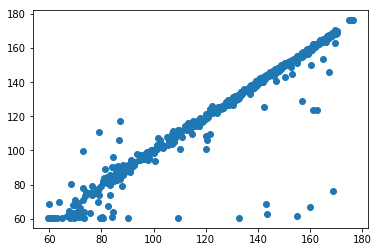

In [10]:
Y_pred = model.predict(X_test)
Y_test = Y_test * 150 + 50
Y_pred = Y_pred * 150 + 50
plt.figure
plt.scatter(Y_test, Y_pred)
Y_error = abs(Y_pred - Y_test)
print('The avarage predict error: ', np.mean(Y_error))
print('The mean squared error:', metrics.mean_squared_error(Y_test, Y_pred))

The avarage predict error:  2.03844406255
The mean squared error: 66.1765994418


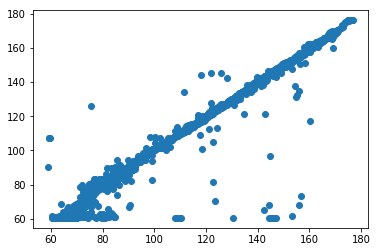

In [11]:
Y_pred = model.predict(X_train)
Y_train = Y_train * 150 + 50
Y_pred = Y_pred * 150 + 50
plt.figure
plt.scatter(Y_train, Y_pred)
Y_error = abs(Y_pred - Y_train)
print('The avarage predict error: ', np.mean(Y_error))
print('The mean squared error:', metrics.mean_squared_error(Y_train, Y_pred))

In [12]:
# Using the best model
model.load_weights("weights.best3.hdf5")

The avarage predict error:  1.11503109447
The mean squared error: 8.04225420517


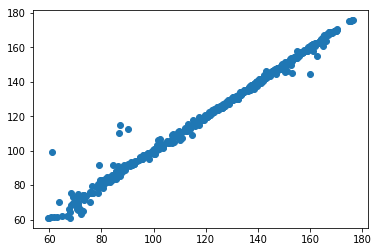

In [13]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred * 150 + 50
plt.figure
plt.scatter(Y_test, Y_pred)
Y_error = abs(Y_pred - Y_test)
print('The avarage predict error: ', np.mean(Y_error))
print('The mean squared error:', metrics.mean_squared_error(Y_test, Y_pred))

The avarage predict error:  0.559224012242
The mean squared error: 0.886402409133


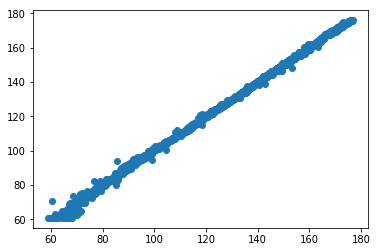

In [14]:
Y_pred = model.predict(X_train)
#Y_train = Y_train * 150 + 50
Y_pred = Y_pred * 150 + 50
plt.figure
plt.scatter(Y_train, Y_pred)
Y_error = abs(Y_pred - Y_train)
print('The avarage predict error: ', np.mean(Y_error))
print('The mean squared error:', metrics.mean_squared_error(Y_train, Y_pred))

ValueError: x and y must be the same size

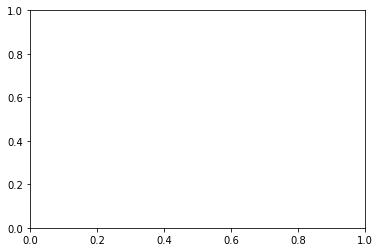

In [15]:
# round
Y_pred = np.around(Y_pred)
Y_test = np.around(Y_test)
plt.figure
plt.scatter(Y_test, Y_pred)
Y_error = abs(Y_pred - Y_test)
print('The avarage predict error: ', np.mean(Y_error))
print('The mean squared error:', metrics.mean_squared_error(Y_test, Y_pred))

In [ ]:
model.summary()